In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,Input,BatchNormalization,Activation,MaxPool2D,Conv2DTranspose,Concatenate,Resizing,MaxPooling2D
import cv2
from matplotlib import pyplot as pp
import os
from glob import glob
from PIL import Image
import numpy as np
from google.colab import drive
import tensorflow as tf
from skimage import color

In [2]:
drive.mount('/content/drive') #The dataset is on google drive

Mounted at /content/drive


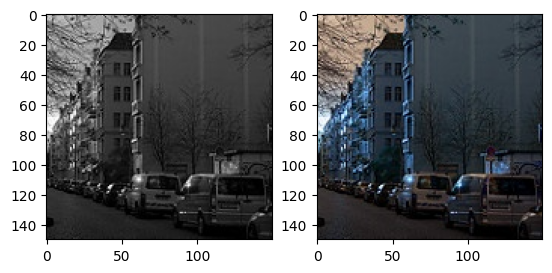

In [8]:
color_path = '/content/drive/MyDrive/GreyRGB/Data/color/'
gray_path = '/content/drive/MyDrive/GreyRGB/Data/gray/'

#Let's display a sample image to see what we're working with
img1 = cv2.imread(gray_path+'0.jpg')
img2 = cv2.imread(color_path+'0.jpg')
pp.subplot(1,2,1)
pp.imshow(img1)
pp.subplot(1,2,2)
pp.imshow(img2)
pp.show()

In [92]:
#Now let's start prepping our dataset before we work on fitting a CNN model
#the file names are same under both color and gray folders so we can create a list of files names from either

file_names = sorted(os.listdir(gray_path))
X = []
Y = []
count = 0
for f in file_names:
  if count >= 3000:
    break
  gray_img = cv2.imread(gray_path+f)
  color_img = cv2.imread(color_path+f)

  gray_img = cv2.resize(gray_img,(96,96))
  color_img = cv2.resize(color_img,(96,96))

  color_img = cv2.cvtColor(color_img,cv2.COLOR_BGR2RGB)
  gray_img = gray_img[:,:,0]

  color_img = color_img.astype("float32") / 255.0;
  gray_img = gray_img.astype("float32") / 255.0;

  X.append(gray_img[...,np.newaxis])
  Y.append(color_img)
  count = count + 1

X = np.array(X)
Y = np.array(Y)
print(X.shape)
print(Y.shape)

(3000, 96, 96, 1)
(3000, 96, 96, 3)


In [109]:
#Now we can create a tensorflow dataset

dataset = tf.data.Dataset.from_tensor_slices((X,Y))

dataset = (dataset.shuffle(buffer_size=len(X)).batch(4).prefetch(tf.data.AUTOTUNE))

tst_sz = int(0.2*len(X))
train = dataset.skip(tst_sz)
test = dataset.take(tst_sz)

In [110]:
#Now, let's start working on the CNN model itself
#The layout will be an encoder -> botteneck layer -> decoder format, similar to the U-net
#We will create separate functions for encoder and decoder blocks

#First, the encoder block
def encoder_block(input_tensor, filters):
    x = Conv2D(filters, 3, padding="same", activation="relu")(input_tensor)
    x = Conv2D(filters, 3, padding="same", activation="relu")(x)
    p = MaxPooling2D(2)(x)
    return x, p

In [111]:
#Now the decoder block
def decoder_block(input_tensor, skip_tensor, filters):
    x = Conv2DTranspose(filters, 2, strides=2, padding="same")(input_tensor)
    x = Concatenate()([x, skip_tensor])
    x = Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = Conv2D(filters, 3, padding="same", activation="relu")(x)
    return x

In [112]:
#Finally, the actual U-Net
def build_unet(input_shape=(96, 96, 1)):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    # Bottleneck
    b = tf.keras.layers.Conv2D(512, 3, padding="same", activation="relu")(p4)
    b = tf.keras.layers.Conv2D(512, 3, padding="same", activation="relu")(b)

    # Decoder
    d1 = decoder_block(b, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = tf.keras.layers.Conv2D(3, 1, padding="same", activation="sigmoid")(d4)

    model = tf.keras.Model(inputs, outputs)
    return model

In [113]:
#Let us tabulate the model summary once, to get an idea of how many parameters there will be
t_model = build_unet()
t_model.summary()

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 96, 96, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_456 (Conv2D) │ (None, 96, 96,    │        320 │ input_layer_24[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_457 (Conv2D) │ (None, 96, 96,    │      9,248 │ conv2d_456[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_96    │ (None, 48, 48,    │          0 │ conv2d_457[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_458 (Conv2D) │ (None, 48, 48,    │     18,496 │ max_pooling2d_96… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_459 (Conv2D) │ (None, 48, 48,    │     36,928 │ conv2d_458[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_97    │ (None, 24, 24,    │          0 │ conv2d_459[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_460 (Conv2D) │ (None, 24, 24,    │     73,856 │ max_pooling2d_97… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_461 (Conv2D) │ (None, 24, 24,    │    147,584 │ conv2d_460[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_98    │ (None, 12, 12,    │          0 │ conv2d_461[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_462 (Conv2D) │ (None, 12, 12,    │    295,168 │ max_pooling2d_98… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_463 (Conv2D) │ (None, 12, 12,    │    590,080 │ conv2d_462[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_99    │ (None, 6, 6, 256) │          0 │ conv2d_463[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_464 (Conv2D) │ (None, 6, 6, 512) │  1,180,160 │ max_pooling2d_99… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_465 (Conv2D) │ (None, 6, 6, 512) │  2,359,808 │ conv2d_464[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_96 │ (None, 12, 12,    │    524,544 │ conv2d_465[0][0]  │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_96      │ (None, 12, 12,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ conv2d_463[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,759,587 (29.60 MB)

 Trainable params: 7,759,587 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

In [114]:
#now let us talk about the loss function
#Typically, for an image recoloring task, we want to use => MAE + SSIM loss combined as it produces sharper colours in the output

def ssim_loss(y_true,y_pred):
  return 1- tf.reduce_mean(tf.image.ssim(y_true,y_pred,max_val=0.1))

def total_loss(y_true,y_pred):
  return 0.1*tf.reduce_mean(tf.abs(y_true-y_pred)) + 0.2*ssim_loss(y_true,y_pred) #usually a value around 0.2 is used in standard practice

In [115]:
#Now, we define our model and its optimization

model = build_unet()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),loss=total_loss,metrics=["mae"])

In [117]:
#Finally, we train our model
hist = model.fit(train,validation_data=test,epochs=100,verbose=True)

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - loss: 0.0237 - mae: 0.0571 - val_loss: 0.0241 - val_mae: 0.0571
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 0.0240 - mae: 0.0586 - val_loss: 0.0242 - val_mae: 0.0591
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 0.0240 - mae: 0.0600 - val_loss: 0.0238 - val_mae: 0.0561
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 0.0215 - mae: 0.0541 - val_loss: 0.0238 - val_mae: 0.0553
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - loss: 0.0228 - mae: 0.0552 - val_loss: 0.0236 - val_mae: 0.0585
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 0.0227 - mae: 0.0547 - val_loss: 0.0227 - val_mae: 0.0544
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - loss: 0.0239 - mae: 0.0558 - val_loss: 0.0231 - val_mae: 0.0545
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - loss: 0.0223 - mae: 0.0552 - val_loss: 0.0225 - val_mae: 0.0555
Epoch 9/100
150/150 ━━━━━━━━━━━━━━━━━━━━

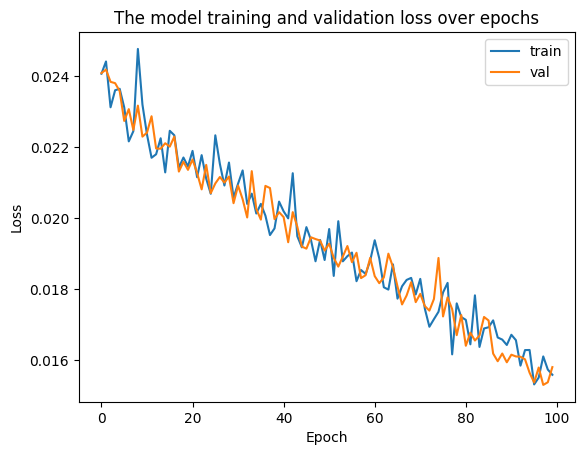

In [125]:
pp.plot(hist.history['loss'])
pp.plot(hist.history['val_loss'])
pp.xlabel('Epoch')
pp.ylabel('Loss')
pp.legend(['train','val'])
pp.title('The model training and validation loss over epochs')
pp.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


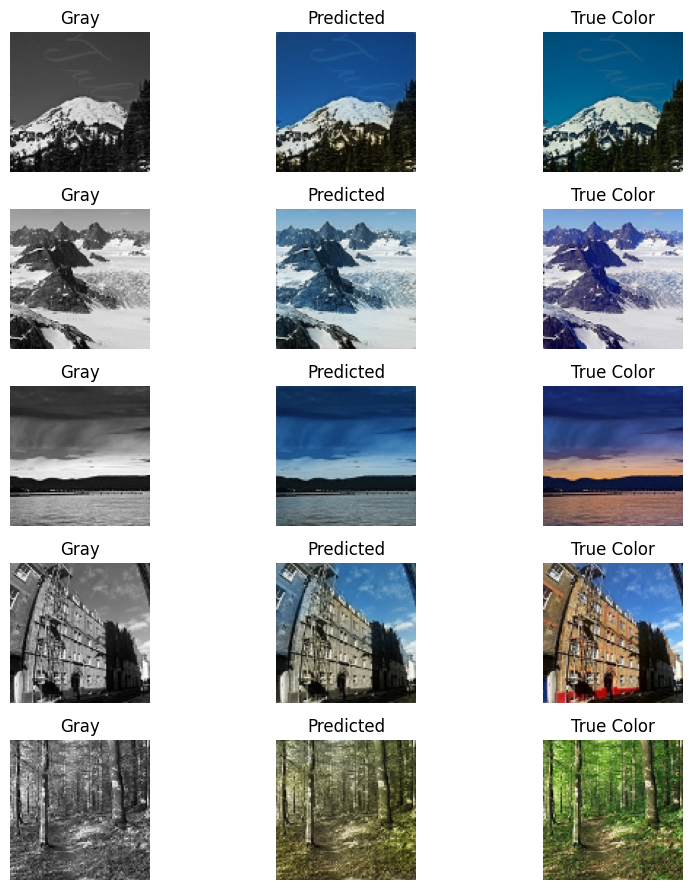

In [122]:
#Now lets visualize for one image, how our model is predicting
sample_ids = ['3002','3001','6333', '7006', '5004']

pp.figure(figsize=(9, 9))

for idx, img_id in enumerate(sample_ids):


    img1 = cv2.imread(gray_path + img_id + '.jpg')
    img2 = cv2.imread(color_path + img_id + '.jpg')


    gray_img = cv2.resize(img1, (96, 96))
    color_img = cv2.resize(img2, (96, 96))


    gray_img = gray_img[:, :, 0] / 255.0
    color_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB) / 255.0


    pred_img = model.predict(gray_img[np.newaxis, ...])[0]


    row = idx * 3 + 1  # position offset for each row

    pp.subplot(5, 3, row)
    pp.imshow(gray_img, cmap='gray')
    pp.title(f"Gray")
    pp.axis('off')

    pp.subplot(5, 3, row + 1)
    pp.imshow(pred_img)
    pp.title("Predicted")
    pp.axis('off')

    pp.subplot(5, 3, row + 2)
    pp.imshow(color_img)
    pp.title("True Color")
    pp.axis('off')

pp.tight_layout()
pp.show()

In [ ]:
#The color sharpness is not efficient and the colors themselves are dull for some samples. For example, in the above 4th and 5th rows, the color separation could be better.
#Let us think of ways we can improve on our model
#The three things that we can change are -> our data, our model architecture and our loss function.

#One of the most promiment improvements used in academic studies is the usage of LAB color space over RGB since it reduces the prediction channels from 3 to 2, making prediction easier.

#Therefore, in short, let us make the following improvement:
#1. RGB -> LAB color space

In [136]:
#Our new dataset will take the Lumination component (very similar to grayscale) and output the ab channel of LAB form
#After prediction, we will re-add the L component to get our final image and compare the performance
X = []
Y = []
count = 0
file_names = sorted(os.listdir(gray_path))

for f in file_names:
  if count >= 3000:
    break
  gray_img = cv2.imread(gray_path+f,cv2.IMREAD_GRAYSCALE)
  color_img = cv2.imread(color_path+f)

  color_img = cv2.cvtColor(color_img,cv2.COLOR_BGR2LAB).astype("float32")

  gray_img = cv2.resize(gray_img,(96,96))
  color_img = cv2.resize(color_img,(96,96))

  gray_img = gray_img[...,np.newaxis]
  color_img = color_img[:,:,1:]

  color_img = (color_img - 128) / 128;
  gray_img = gray_img / 255.0 * 100.0;

  X.append(gray_img)
  Y.append(color_img)
  count = count + 1

X = np.array(X)
Y = np.array(Y)
print(X.shape)
print(Y.shape)

(3000, 96, 96, 1)
(3000, 96, 96, 2)


In [137]:
#Now we can create a tensorflow dataset again

dataset = tf.data.Dataset.from_tensor_slices((X,Y))

dataset = (dataset.shuffle(buffer_size=len(X)).batch(4).prefetch(tf.data.AUTOTUNE))

tst_sz = int(0.2*len(X))
train = dataset.skip(tst_sz)
test = dataset.take(tst_sz)

In [138]:
def conv_block(x, filters):
    x = tf.keras.layers.Conv2D(filters, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2D(filters, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    return x

In [139]:
#Small changes that we need to make to our final model function, to adjust for new output shape
def build_unet_LAB(input_shape=(96, 96, 1)):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    # Bottleneck
    b = conv_block(p4, 512)

    # Decoder
    d1 = decoder_block(b, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)


    outputs = tf.keras.layers.Conv2D(2, 1, padding="same", activation="tanh")(d4)

    model = tf.keras.Model(inputs, outputs)
    return model

In [140]:
def total_loss_v2(y_true, y_pred):
  huber = tf.keras.losses.Huber(delta=1.5) #Huber loss makes use of the benefits of both MAE and MSE and is an opt choice here

  loss = 0.01 * tf.reduce_mean(huber(y_true, y_pred)*5.0) + tf.reduce_mean(tf.abs(y_true - y_pred) * (1.0 + tf.abs(y_true))) #The weight added of y_true is for increasing color sharpness.
  return loss

In [141]:
#now lets compile and fit our new model with the improvements

modelv2 = build_unet_LAB()
modelv2.compile(optimizer=tf.keras.optimizers.Adam(5e-4),loss=total_loss_v2,metrics=["mae"])

histv2 = modelv2.fit(train,validation_data=test,epochs=100,verbose=True)

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - loss: 0.2831 - mae: 0.2564 - val_loss: 0.1147 - val_mae: 0.1018
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 0.0895 - mae: 0.0781 - val_loss: 0.0824 - val_mae: 0.0703
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 0.0812 - mae: 0.0697 - val_loss: 0.0809 - val_mae: 0.0693
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 0.0817 - mae: 0.0701 - val_loss: 0.0809 - val_mae: 0.0694
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0815 - mae: 0.0697 - val_loss: 0.0794 - val_mae: 0.0681
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 0.0756 - mae: 0.0651 - val_loss: 0.0785 - val_mae: 0.0672
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0830 - mae: 0.0707 - val_loss: 0.0791 - val_mae: 0.0683
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0748 - mae: 0.0649 - val_loss: 0.0803 - val_mae: 0.0696
Epoch 9/100
150/150 ━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


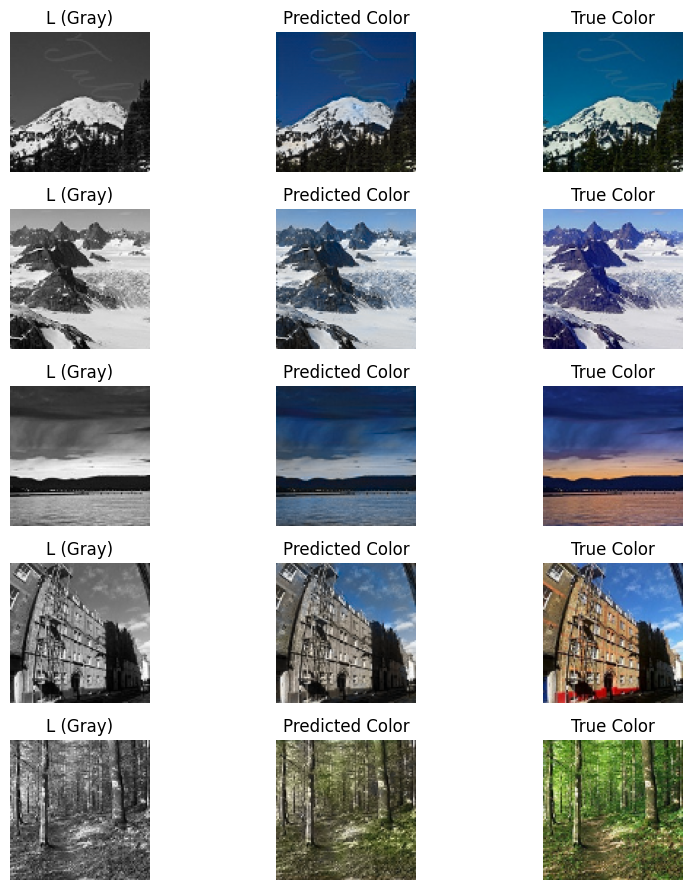

In [142]:
#Now let us see how this new model does on the same image we checked before

sample_ids = ['3002','3001','6333', '7006', '5004']

pp.figure(figsize=(9, 9))

for idx, img_id in enumerate(sample_ids):


    img_gray = cv2.imread(gray_path + img_id + '.jpg', cv2.IMREAD_GRAYSCALE)
    img_color = cv2.imread(color_path + img_id + '.jpg')


    img_gray = cv2.resize(img_gray, (96, 96))
    img_color = cv2.resize(img_color, (96, 96))


    L = img_gray / 255.0 * 100.0
    L_input = L[..., np.newaxis]

    true_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB) / 255.0


    pred_ab = modelv2.predict(L_input[np.newaxis, ...])[0]


    pred_ab = pred_ab * 128


    lab_pred = np.concatenate([L[..., np.newaxis], pred_ab], axis=-1)
    rgb_pred = color.lab2rgb(lab_pred)


    row = idx * 3 + 1

    pp.subplot(5, 3, row)
    pp.imshow(L, cmap="gray")
    pp.title("L (Gray)")
    pp.axis("off")

    pp.subplot(5, 3, row + 1)
    pp.imshow(rgb_pred)
    pp.title("Predicted Color")
    pp.axis("off")

    pp.subplot(5, 3, row + 2)
    pp.imshow(true_rgb)
    pp.title("True Color")
    pp.axis("off")

pp.tight_layout()
pp.show()

In [143]:
modelv2.summary()

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, 96, 96, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_532 (Conv2D) │ (None, 96, 96,    │        320 │ input_layer_28[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_533 (Conv2D) │ (None, 96, 96,    │      9,248 │ conv2d_532[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_112   │ (None, 48, 48,    │          0 │ conv2d_533[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_534 (Conv2D) │ (None, 48, 48,    │     18,496 │ max_pooling2d_11… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_535 (Conv2D) │ (None, 48, 48,    │     36,928 │ conv2d_534[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_113   │ (None, 24, 24,    │          0 │ conv2d_535[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_536 (Conv2D) │ (None, 24, 24,    │     73,856 │ max_pooling2d_11… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_537 (Conv2D) │ (None, 24, 24,    │    147,584 │ conv2d_536[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_114   │ (None, 12, 12,    │          0 │ conv2d_537[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_538 (Conv2D) │ (None, 12, 12,    │    295,168 │ max_pooling2d_11… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_539 (Conv2D) │ (None, 12, 12,    │    590,080 │ conv2d_538[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_115   │ (None, 6, 6, 256) │          0 │ conv2d_539[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_540 (Conv2D) │ (None, 6, 6, 512) │  1,180,160 │ max_pooling2d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 6, 512) │      2,048 │ conv2d_540[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 6, 6, 512) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_541 (Conv2D) │ (None, 6, 6, 512) │  2,359,808 │ re_lu_20[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 6, 512) │      2,048 │ conv2d_541[0][0]

 Total params: 23,286,856 (88.83 MB)

 Trainable params: 7,761,602 (29.61 MB)

 Non-trainable params: 2,048 (8.00 KB)

 Optimizer params: 15,523,206 (59.22 MB)

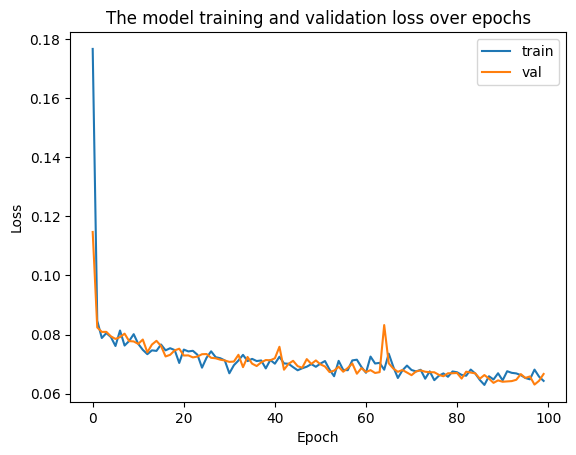

In [144]:
pp.plot(histv2.history['loss'])
pp.plot(histv2.history['val_loss'])
pp.xlabel('Epoch')
pp.ylabel('Loss')
pp.legend(['train','val'])
pp.title('The model training and validation loss over epochs')
pp.show()